The purpose of this notebook will be to leverage on the CIFAR-10 dataset, and test how effective LeNet-5 can acccurately classify the images. The 1st section of the notebook will be about describing the CIFAR-10 dataset, and also creating a base LeNet5 model and understanding how each layer is processing the images. The 2nd section of the notebook will be about enhancing the base LeNet-5 model, as well as including additional steps for data pre-processing, data augmentation and regularization to get better classification results.

CIFAR-10 is an established image dataset collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton that is used for object recognition. The CIFAR-10 data consists of 60,000 (32×32) color images in 10 classes, with 6000 images per class. There are 50,000 training images and 10,000 test images in the official data. The 10 label classes in the dataset are:

- airplane
- automobile
- bird
- cat
- deer
- dog
- frog
- horse
- ship
- truck

The below code shows 16 sample images from the CIFAR-10 dataset:

*Refence: https://appliedmachinelearning.blog/2018/03/24/achieving-90-accuracy-in-object-recognition-task-on-cifar-10-dataset-with-keras-convolutional-neural-networks/*

Let's use this as a common function to display sample images throughout the notebook.

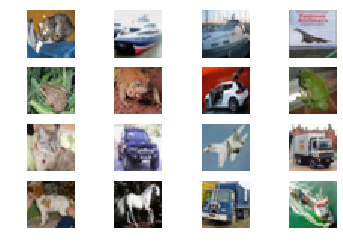

In [35]:
from matplotlib import pyplot
from keras.datasets import cifar10 
from keras.models import model_from_json
from scipy.misc import toimage
from PIL import Image

def show_imgs(X):
    pyplot.figure(1)
    k = 0
    for i in range(0,4):
        for j in range(0,4):
            pyplot.subplot2grid((4,4),(i,j))
            pyplot.imshow(Image.fromarray(X[k]))
            pyplot.axis('off')
            k = k+1
    # show the plot
    pyplot.show()
 
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
show_imgs(x_test[:16])

Let's import all the other additional packages/libraries that are need.

In [2]:
import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import cifar10
from keras import regularizers
from keras.callbacks import LearningRateScheduler, EarlyStopping
from keras import callbacks
import numpy as np
from keras.models import Model
import math

Now let's initialise variables that can be used throughout the notebook, so that we don't have to hardcode the values and also allow us to easily change parameters such as batch_size, epochs etc.

We will also specify the file names where the model will be generated and written to a physical location. This is so that each time we want to run the model, there's no need to re-run/compile the model again. This will be useful if we just want to tweak data pre-processing inputs and see how it affects the accuracy, without making actual changes to the model.

In [3]:
#Input image dimensions
img_rows, img_cols = 32, 32

batch_size = 64
num_classes = 10
epochs = 100

#Labels
labels =  ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

#LeNet5 Model and weight file name
lenet5_model_name = 'lenet5_model.json'
lenet5_weight_name = 'lenet5_model.h5'

#Customised Model and weight file name
custom_lenet5_model_name = 'custom_lenet5_model.json'
custom_lenet5_weight_name = 'custom_lenet5_model.h5'

We will load the CIFAR0 dataset and also do some simple data pre-processing such as changing the x_train and x_test data type to float32, and also normalizing the data using Z-Score Normalization (Standardization).

We want to ensure that each input pixel has a similar data distribution. This makes convergence faster while training the network. Data normalization is done by subtracting the mean from each pixel, and then dividing the result by the standard deviation.

The below sample images shows how the images look like after normalization.

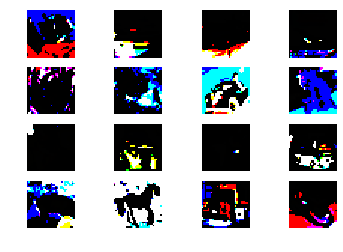

In [4]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
 
#z-score
mean = np.mean(x_train,axis=(0,1,2,3))
std = np.std(x_train,axis=(0,1,2,3))
x_train = (x_train-mean)/(std+1e-7)
x_test = (x_test-mean)/(std+1e-7)

y_train = np_utils.to_categorical(y_train,num_classes)
y_test = np_utils.to_categorical(y_test,num_classes)

show_imgs(x_test[:16].astype('uint8'))

Now we will define and create the LeNet-5 model.

**LeNet-5**

LeNet-5, a pioneering 7-level convolutional network by LeCun et al. in 1998, that classifies digits, was applied by several banks to recognise hand-written numbers on checks (cheques) digitized in 32x32 pixel images. The ability to process higher resolution images requires larger and more layers of convolutional neural networks, so this technique is constrained by the availability of computing resources.

LeNet-5 network has 2 times of filtering and pooling (4 layers)→ 2 layers of fully connected → soft max func → labels.

In [5]:
# LeNet-5

model = Sequential()

# first set of CONV => RELU => POOL
model.add(Conv2D(6, kernel_size=(5,5), 
                        strides=(1,1),
                        padding='same', # adds sufficient padding to the input so that the output has same dimension as input
                        input_shape=x_train.shape[1:],
                        use_bias=True, 
                        kernel_initializer='glorot_uniform',
                        bias_initializer='zeros'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# second set of CONV => RELU => POOL
model.add(Conv2D(16, kernel_size=(5,5), 
                        padding='valid'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))


model.add(Conv2D(120, kernel_size=(5,5),
                 padding='valid'))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dense(84))

# softmax classifier
model.add(Dense(num_classes))
model.add(Activation('softmax'))

Below is a summary of the model, together with the layer type, output shape and number of parameters.

In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 6)         456       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 6)         0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 6)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 16)        2416      
_________________________________________________________________
activation_2 (Activation)    (None, 12, 12, 16)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 16)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 2, 2, 120)         48120     
__________

**Data Augmentation**

Here we will do one additional step of data augmentation to generate batches of image data with real-time data augmentation. The data will be looped over (in batches) indefinitely. The image data is generated by transforming the actual training images by rotation, crop, shifts, shear, zoom, flip, reflection, normalization etc.

*Reference: https://towardsdatascience.com/image-augmentation-for-deep-learning-using-keras-and-histogram-equalization-9329f6ae5085*

In [7]:
datagen = ImageDataGenerator( rotation_range=90, 
                 width_shift_range=0.1, height_shift_range=0.1, 
                 horizontal_flip=True) 
datagen.fit(x_train)

**Learning Rate Schedule For Training Models**

We will adapt the learning rate to increase performance and reduce training time. A learning rate schedule approach will be deployed, where the default schedule is to use a constant learning rate to update network weights for each training epoch.

We are using a simple adaptation of learning rate during training (reduce the learning rate over time). These have the benefit of making large changes at the beginning of the training procedure when larger learning rate values are used, and decreasing the learning rate such that a smaller rate and therefore smaller training updates are made to weights later in the training procedure.

*Reference:
https://machinelearningmastery.com/using-learning-rate-schedules-deep-learning-models-python-keras/*

In [8]:
def learning_schedule(epoch):
    initial_lrate = 0.001
    drop = 0.5
    epochs_drop = 20.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

Let's compile and train the LeNet-5 model.

In [9]:
opt_rms = keras.optimizers.rmsprop(lr=0.001,decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])
model_log = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),\
                    steps_per_epoch=x_train.shape[0] // batch_size,epochs=epochs,\
                    verbose=1,validation_data=(x_test,y_test),callbacks=[LearningRateScheduler(learning_schedule)])

Epoch 1/100
781/781 [==============================] - 27s 34ms/step - loss: 1.8206 - acc: 0.3418 - val_loss: 1.5895 - val_acc: 0.4348
Epoch 2/100
781/781 [==============================] - 23s 29ms/step - loss: 1.6234 - acc: 0.4172 - val_loss: 1.4956 - val_acc: 0.4657
Epoch 3/100
781/781 [==============================] - 23s 29ms/step - loss: 1.5426 - acc: 0.4453 - val_loss: 1.5223 - val_acc: 0.4592
Epoch 4/100
781/781 [==============================] - 23s 29ms/step - loss: 1.4889 - acc: 0.4635 - val_loss: 1.4653 - val_acc: 0.4906
Epoch 5/100
781/781 [==============================] - 23s 29ms/step - loss: 1.4516 - acc: 0.4851 - val_loss: 1.5640 - val_acc: 0.4567
Epoch 6/100
781/781 [==============================] - 23s 29ms/step - loss: 1.4220 - acc: 0.4909 - val_loss: 1.3372 - val_acc: 0.5228
Epoch 7/100
781/781 [==============================] - 23s 29ms/step - loss: 1.3994 - acc: 0.5008 - val_loss: 1.3131 - val_acc: 0.5391
Epoch 8/100
781/781 [==============================] - 

We will also define a function to plot the train & validation accuracy and loss values, and call it to show the relationship.

In [10]:
def plot_accuracy_loss(model_log):
    f, (ax1, ax2) = pyplot.subplots(1, 2,figsize=(15,5))

    ax1.plot(model_log.history['acc'])
    ax1.plot(model_log.history['val_acc'])
    ax1.set_title('Accuracy (Higher Better)')
    ax1.set(xlabel='Epoch', ylabel='Accuracy')
    ax1.legend(['train', 'validation'], loc='lower right')

    ax2.plot(model_log.history['loss'])
    ax2.plot(model_log.history['val_loss'])
    ax2.set_title('Loss (Lower Better)')
    ax2.set(xlabel='Epoch', ylabel='Loss')
    ax2.legend(['train', 'validation'], loc='upper right')

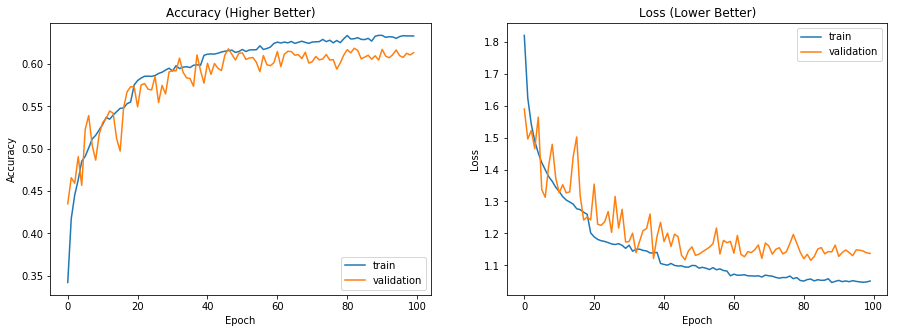

In [11]:
plot_accuracy_loss(model_log)  

Let's save the model and weights to the disk so that it can be loaded for future use. The classification accuracy and loss are also printed below.

In [12]:
#save to disk
model_json = model.to_json()
with open(lenet5_model_name, 'w') as json_file:
    json_file.write(model_json)
model.save_weights(lenet5_weight_name) 
  
#testing
scores = model.evaluate(x_test, y_test, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

10000/10000 [==============================] - 1s 91us/step

Test result: 61.340 loss: 1.137


**LeNet-5 Is Not Ideal for Image Classification**

In this case, LeNet-5 might not be so suitable to classify images as the accuracy is around 60%.

Let's sample 16 images and see how the LeNet-5 model classifies the images. We will load the model and weights from the json_file that we have just created. The classified labels are displayed below the images.

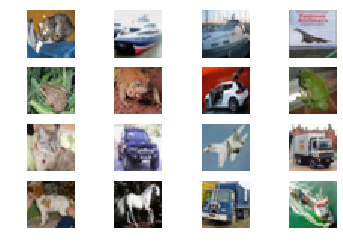

['frog', 'ship', 'ship', 'airplane', 'frog', 'frog', 'automobile', 'frog', 'cat', 'automobile', 'airplane', 'truck', 'dog', 'horse', 'truck', 'ship']


In [13]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
 
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

show_imgs(x_test[:16].astype('uint8'))

# mean-std normalization
mean = np.mean(x_train,axis=(0,1,2,3))
std = np.std(x_train,axis=(0,1,2,3))
x_train = (x_train-mean)/(std+1e-7)
x_test = (x_test-mean)/(std+1e-7)
 
# Load trained CNN model
json_file = open(lenet5_model_name, 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights(lenet5_weight_name)
 
indices = np.argmax(model.predict(x_test[:16]),1)
print ([labels[x] for x in indices])

**Looking At the Sample Images That Were Wrongly Classified**

Now, let's take 100 images to run through the model and look at 16 sample images that were classified wrongly.

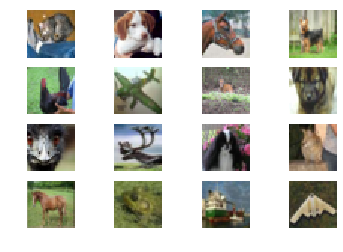

['frog', 'cat', 'truck', 'deer', 'deer', 'bird', 'bird', 'frog', 'automobile', 'airplane', 'cat', 'frog', 'deer', 'deer', 'truck', 'horse']


In [14]:
output = model.predict_classes(x_test[:100])
#output = model.predict_classes(x_test)
#print (output)
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
err_ind = np.where(np.equal(output, y_test[:100,0])==0)
#err_ind = np.where(np.equal(output, y_test[0])==0)
#print (err_ind[0])

err_x = x_test[err_ind[0]]
#print (err_x.shape)
err_y = err_ind[0]
#print (y_test[:16,0])
show_imgs(err_x[:16].astype('uint8'))
err_y_label=[]
#print ([labels[x] for x in err_y])

for i, idx in enumerate(err_y[:16]):
    #pyplot.subplot(len(err_y), len(err_y), i * len(err_y) + 1)
    #pyplot.imshow(err_x[i].astype('uint8'), cmap = 'gray')
    #pyplot.axis('off')
    #print('idx')
    #print(idx)
    #pyplot.title(labels[output[idx]])
    err_y_label.append(labels[output[idx]])
print(err_y_label)


**Understanding of the Layers in LetNet-5**

To further understand how LeNet-5 is classifying the images, we will now attempt to look at how LetNet-5 is handling an image whilst processing it via its convolutional network.

We will take only one image as a sample.

*Reference: https://www.kaggle.com/amarjeet007/visualize-cnn-with-keras*

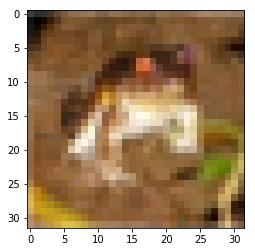

['frog']


In [15]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
 
x_train = x_train.astype('float32')

pyplot.imshow(x_train[0].astype('uint8'), cmap = 'gray')
pyplot.show()
print ([labels[x] for x in y_train[0]])

mean = np.mean(x_train,axis=(0,1,2,3))
std = np.std(x_train,axis=(0,1,2,3))
x_train = (x_train-mean)/(std+1e-7)
x_test = (x_test-mean)/(std+1e-7)

layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(x_train[0].reshape(1,img_rows, img_cols, 3))
 
def display_activation(activations, col_size, row_size, act_index): 
    activation = activations[act_index]
    activation_index=0
    fig, ax = pyplot.subplots(row_size, col_size, figsize=(row_size*2.5,col_size*1.5))
    #fig, ax = pyplot.subplots(row_size, col_size, figsize=(row_size*5,col_size*5))
    for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].imshow(activation[0, :, :, activation_index], cmap='gray')
            activation_index += 1

**Layer 1: 1st Conv2D** 

6 filters of 5 x 5 and stride 1.

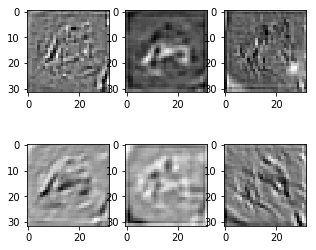

In [16]:
display_activation(activations, 3, 2, 0)

**Layer 2: 1st Activation (Relu)**


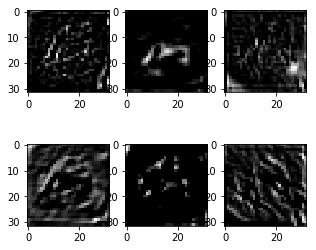

In [17]:
display_activation(activations, 3, 2, 1)


**Layer 3: 1st Max Pooling**

2 x 2 with strides 2

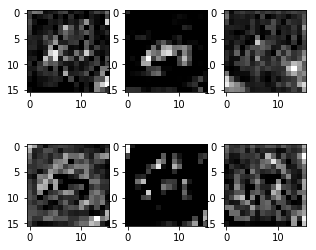

In [18]:
display_activation(activations, 3, 2, 2)

**Layer 4: 2nd Conv2D**

16 filters of 5 x 5 with stride 1

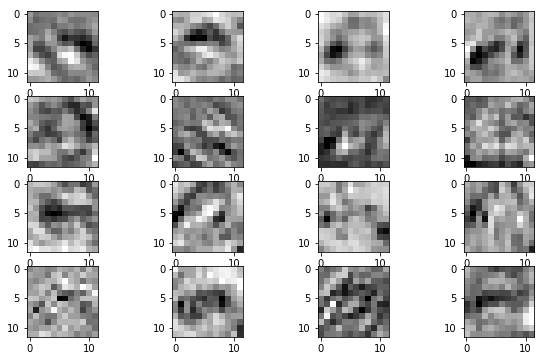

In [19]:
display_activation(activations, 4, 4, 3)

**Layer 5: 2nd Activation (Relu)**

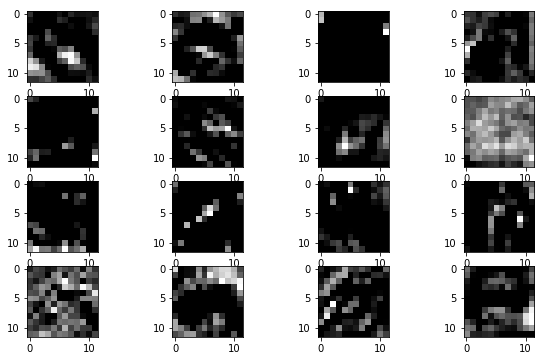

In [20]:
display_activation(activations, 4, 4, 4)

**Layer 6: 2nd Max Pooling**

2 x 2 with strides 2

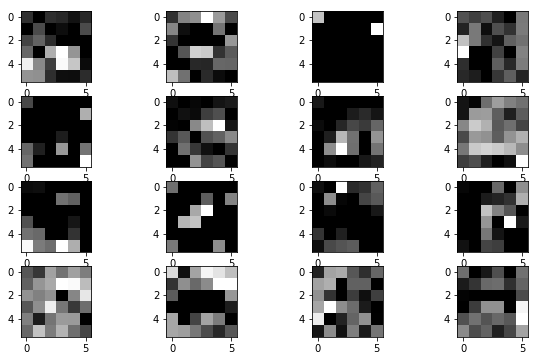

In [21]:
display_activation(activations, 4, 4, 5)

**Layer 7 + 8 + 9: Flatten and Dense**

These 3 layers flatten and image and goes through full connected dense layers of 120, 84, 10 and then going through SoftMax to compute the classification probability. 

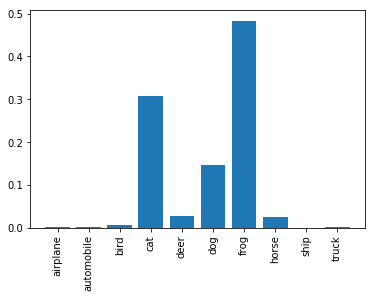

In [22]:
act_dense_3  = activations[11]
 
y = act_dense_3[0]
x = range(len(y))
pyplot.xticks(x, labels, rotation='vertical')
pyplot.bar(x, y)
pyplot.show()


**LeNet-5 Summary**

In this exercise, we see that we are getting hits for the following: 
- 'bird'
- 'cat'
- 'deer'
- 'dog'
- 'frog'
- 'horse'
- 'truck'

LeNet-5 manages to classify this image as a 'frog' as it got the highest hit count. 

However, the probability values of 'frog' and other values are too close, and hence this might explain why LeNet-5 is only able to produce a classification accuracy of 60% for the images.

**Customising LeNet-5**

Now that we know how LeNet-5 is processing the images, let's try to tweak the model so that we can get a higher accuracy.

The 1st thing we will do is tackle the convolution layers. LeNet-5 was designed for digit classification, each stroke and characteristics of the digits are quite broad, hence that's why 6 filters of 5 x 5 could be sufficient for LeNet-5 when doing digit classification.

In our case, since we are classifying CIFAR-10 images, let's increase the number of filters to 32, and also cut down the filter size to 3 x 3, so that each filter is able to handle more fine-grained characteristics.

We will then multiply the number of filters by 2 for each of the next convolution layers as well.

**Early Stopping**

We will leave the number of epochs as 100. But since we are also now experimenting and tweaking the model, let's implement Early Stopping in our model callback. Early stopping is basically stopping the training once the loss starts to increase (or in other words validation accuracy starts to decrease).

We will set the patience value as 3. The patience value represents the number of epochs before stopping once our accuracy starts to decrease (stops improving). The value that we will be monitoring is 'val_acc', which is the accuracy score from the validation / testing data set. 

This gives us some leeway as the model will only be stopped if there are 3 epochs of val_acc that doesn't improve.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_5 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
activation_6 (Activation)    (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 6, 6, 128)         73856     
__________

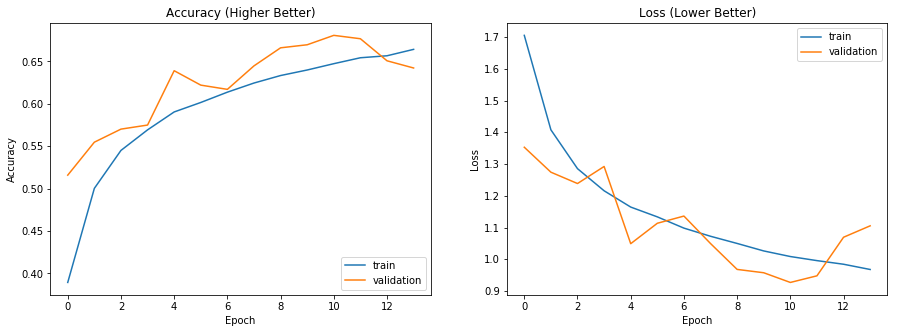

In [23]:
# Customise Lenet-5 filters

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
 
#z-score
mean = np.mean(x_train,axis=(0,1,2,3))
std = np.std(x_train,axis=(0,1,2,3))
x_train = (x_train-mean)/(std+1e-7)
x_test = (x_test-mean)/(std+1e-7)

y_train = np_utils.to_categorical(y_train,num_classes)
y_test = np_utils.to_categorical(y_test,num_classes)

datagen = ImageDataGenerator( rotation_range=90, 
                 width_shift_range=0.1, height_shift_range=0.1, 
                 horizontal_flip=True) 
datagen.fit(x_train)

model = Sequential()

# first set of CONV => change number of filters to 32 and kernel size to be 3 x 3
model.add(Conv2D(32, kernel_size=(3,3), 
                        strides=(1,1),
                        padding='same', # adds sufficient padding to the input so that the output has same dimension as input
                        input_shape=x_train.shape[1:],
                        use_bias=True, 
                        kernel_initializer='glorot_uniform',
                        bias_initializer='zeros'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# second set of CONV => change number of filters to 64 and kernel size to be 3 x 3
model.add(Conv2D(64, kernel_size=(3,3), 
                        padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# change number of filters to 128 and kernel size to be 3 x 3
model.add(Conv2D(128, kernel_size=(3,3),
                 padding='valid'))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dense(84))

# softmax classifier
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

# introduce EarlyStopping callback
opt_rms = keras.optimizers.rmsprop(lr=0.001,decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])
model_log = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),\
                    steps_per_epoch=x_train.shape[0] // batch_size,epochs=epochs,\
                    verbose=1,validation_data=(x_test,y_test),callbacks=[LearningRateScheduler(learning_schedule),\
                                                                         EarlyStopping(monitor='val_acc', mode='max', patience=3)])

plot_accuracy_loss(model_log)  

#save to disk
model_json = model.to_json()
with open('1_Filter_'+ custom_lenet5_model_name, 'w') as json_file:
    json_file.write(model_json)
model.save_weights('1_Filter_'+ custom_lenet5_weight_name) 
  
#testing
scores = model.evaluate(x_test, y_test, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

**Data Pre-Preprocessing, Data Augmentation and Normalisation**

By changing the number of filters and size of the filters, we managed to get an improvement of 3% - 8% in terms of accuracy. 
Looking at the test and validation accuracy and loss charts, there seem to be a possibility of overfitting.

Let's now look at how to further improve the model and avoid overfitting by introducing additional techniques for Data Pre-Processing, Data Augmentation and Normalisation.

**Data Pre-Processing:**
In the initial LeNet-5 model, Z-score normalisation is already used. Let's keep that.

**Data Augmentation:**
Data Augmentation was also done in the initial LeNet-5 model. Let's try to tweak the parameters so that we can get better data intput for training the model. Instead of a 90 degree rotation range, let's set the rotation range to 10 so that enough data is generated for images that are abit off-centered. 

The default for fill_mode is 'nearest'. Let's set the fill_mode to 'constant' with cval =0. 

**Regularisation:**
We will also now introduce L2 Regularisation with Weight Decay of 0.001, and also introduce Dropout. At every iteration, Dropout randomly selects some nodes and removes them along with all of their incoming and outgoing connections. So each iteration has a different set of nodes and this results in a different set of outputs. It can also be thought of as an ensemble technique in machine learning.

Ensemble models usually perform better than a single model as they capture more randomness. Similarly, dropout also performs better than a normal neural network model.


*Reference:*

*http://cs231n.github.io/neural-networks-2/*

*https://www.analyticsvidhya.com/blog/2018/04/fundamentals-deep-learning-regularization-techniques/*

*http://lamda.nju.edu.cn/weixs/project/CNNTricks/CNNTricks.html*

*https://zhuanlan.zhihu.com/p/30197320*

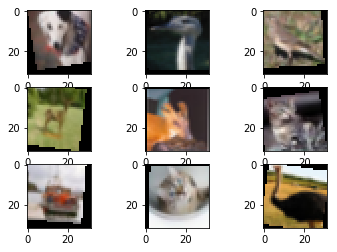

In [24]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
datagen = ImageDataGenerator(rotation_range=10, horizontal_flip=True,
            width_shift_range=0.125,height_shift_range=0.125,fill_mode='constant',cval=0.)
datagen.fit(x_train)

from matplotlib import pyplot as plt
# Configure batch size and retrieve one batch of images
for X_batch, y_batch in datagen.flow(x_train, y_train, batch_size=9):
    # Show 9 images
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        #plt.imshow(toimage(X_batch[i].reshape(img_rows, img_cols, 3)))
        plt.imshow(Image.fromarray(X_batch[i].reshape(img_rows, img_cols, 3).astype('uint8')))
    # show the plot
    plt.show()
    break

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_9 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
activation_10 (Activation)   (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 8, 8, 64)          0         
__________

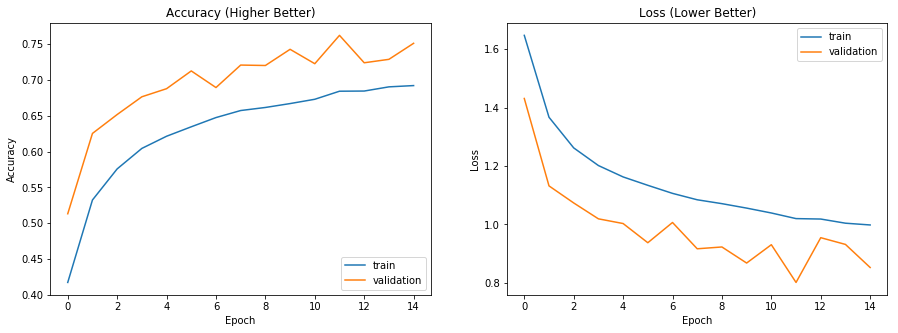

In [25]:
# Customise Lenet with Data Processing, Augmentation and Normalisation

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
 
#z-score
mean = np.mean(x_train,axis=(0,1,2,3))
std = np.std(x_train,axis=(0,1,2,3))
x_train = (x_train-mean)/(std+1e-7)
x_test = (x_test-mean)/(std+1e-7)

y_train = np_utils.to_categorical(y_train,num_classes)
y_test = np_utils.to_categorical(y_test,num_classes)

#Change rotation_range to 10, and fill_mode to constant.
datagen = ImageDataGenerator(rotation_range=10, horizontal_flip=True,
            width_shift_range=0.125,height_shift_range=0.125,fill_mode='constant',cval=0.)
datagen.fit(x_train)

#Define weight Decay
weight_decay = 1e-4
model = Sequential()

# add in L2 weight decay for kernel_regularizer
model.add(Conv2D(32, kernel_size=(3,3), 
                        strides=(1,1),
                        padding='same', # adds sufficient padding to the input so that the output has same dimension as input
                        input_shape=x_train.shape[1:],
                        use_bias=True, 
                        kernel_initializer='glorot_uniform',
                        kernel_regularizer=regularizers.l2(weight_decay),
                        bias_initializer='zeros'))

model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
# add dropout
model.add(Dropout(0.2))

# # add in L2 weight decay for kernel_regularizer
model.add(Conv2D(64, kernel_size=(3,3),kernel_regularizer=regularizers.l2(weight_decay), 
                        padding='same'))

model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
# add dropout
model.add(Dropout(0.3))

# add in L2 weight decay for kernel_regularizer
model.add(Conv2D(128, kernel_size=(3,3),kernel_regularizer=regularizers.l2(weight_decay),
                 padding='valid'))


model.add(Activation('relu'))
#add dropout
model.add(Dropout(0.4))
model.add(Flatten())
# add in L2 weight decay for kernel_regularizer
model.add(Dense(84,kernel_regularizer=regularizers.l2(weight_decay)))

# add in L2 weight decay for kernel_regularizer
model.add(Dense(num_classes,kernel_regularizer=regularizers.l2(weight_decay)))
# softmax classifier
model.add(Activation('softmax'))

model.summary()
opt_rms = keras.optimizers.rmsprop(lr=0.001,decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])
model_log = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),\
                    steps_per_epoch=x_train.shape[0] // batch_size,epochs=epochs,\
                    verbose=1,validation_data=(x_test,y_test),callbacks=[LearningRateScheduler(learning_schedule),\
                                                                         EarlyStopping(monitor='val_acc', mode='max', patience=3)])

plot_accuracy_loss(model_log) 

#save to disk
model_json = model.to_json()
with open('2_DP_DA_R_'+custom_lenet5_model_name, 'w') as json_file:
    json_file.write(model_json)
model.save_weights('2_DP_DA_R_'+custom_lenet5_weight_name) 
  
#testing
scores = model.evaluate(x_test, y_test, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

**Experimenting with Optimizer and Batch Normalization**

With Data Pre-Processing, Augmentation and Normalization, we have achieved higher accuracy scores, in the range of 72% to 76%. 

Let's now try tweaking the optimization, adopting SGD (Stochastic Gradient Descent) instead of RMS.

We will also include BatchNormalization to make the model training faster.

*Reference:*

*https://shaoanlu.wordpress.com/2017/05/29/sgd-all-which-one-is-the-best-optimizer-dogs-vs-cats-toy-experiment/*

*https://www.dlology.com/blog/one-simple-trick-to-train-keras-model-faster-with-batch-normalization/*

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 32, 32, 32)        864       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_13 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 16, 16, 64)        18432     
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 64)        256       
__________

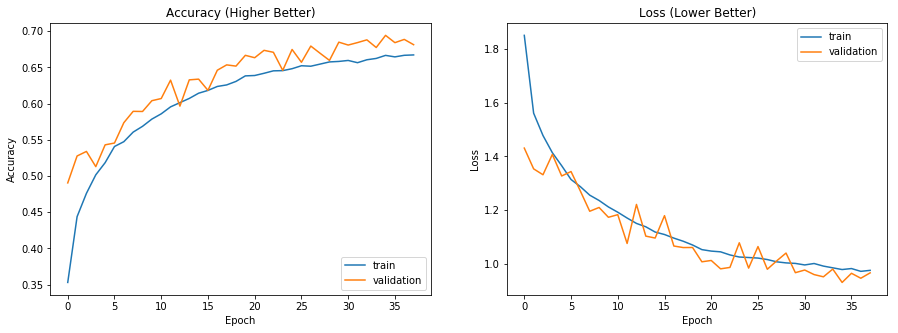

In [26]:
# Customise Lenet with SGD Optimizer and Batch Normalization

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
 
#z-score
mean = np.mean(x_train,axis=(0,1,2,3))
std = np.std(x_train,axis=(0,1,2,3))
x_train = (x_train-mean)/(std+1e-7)
x_test = (x_test-mean)/(std+1e-7)

y_train = np_utils.to_categorical(y_train,num_classes)
y_test = np_utils.to_categorical(y_test,num_classes)

datagen = ImageDataGenerator(rotation_range=10, horizontal_flip=True,
            width_shift_range=0.125,height_shift_range=0.125,fill_mode='constant',cval=0.)
datagen.fit(x_train)

weight_decay = 1e-4
model = Sequential()

model.add(Conv2D(32, kernel_size=(3,3), 
                        strides=(1,1),
                        padding='same', # adds sufficient padding to the input so that the output has same dimension as input
                        input_shape=x_train.shape[1:],
                        use_bias=False, 
                        kernel_initializer='glorot_uniform',
                        kernel_regularizer=regularizers.l2(weight_decay),
                        bias_initializer='zeros'))
# add BatchNormalization()
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, kernel_size=(3,3),kernel_regularizer=regularizers.l2(weight_decay), 
                        use_bias=False,padding='same'))
# add BatchNormalization()
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, kernel_size=(3,3),kernel_regularizer=regularizers.l2(weight_decay),
                 use_bias=False,padding='valid'))
# add BatchNormalization()
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(84,use_bias=False,kernel_regularizer=regularizers.l2(weight_decay)))
# add BatchNormalization()
model.add(BatchNormalization())
model.add(Dense(num_classes,kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('softmax'))

model.summary()
#change optimizer to sgd
#opt_rms = keras.optimizers.rmsprop(lr=0.001,decay=1e-6)
opt_sgd = keras.optimizers.SGD(lr=.1, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=opt_sgd, metrics=['accuracy'])
model_log = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),\
                    steps_per_epoch=x_train.shape[0] // batch_size,epochs=epochs,\
                    verbose=1,validation_data=(x_test,y_test),callbacks=[LearningRateScheduler(learning_schedule),\
                                                                         EarlyStopping(monitor='val_acc', mode='max', patience=3)])

plot_accuracy_loss(model_log) 

#save to disk
model_json = model.to_json()
with open('3_SGD_BN_'+custom_lenet5_model_name, 'w') as json_file:
    json_file.write(model_json)
model.save_weights('3_SGD_BN_'+custom_lenet5_weight_name) 
  
#testing
scores = model.evaluate(x_test, y_test, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

**Final Customised CNN Model**

Looking at the training results, SGD did not increase the accuracy, hence we will revert back to RMS optimizer.

Researching other CNN models, it seems that most of them does multiple convolutions before max pooling.

This is what we will do as well. In our final model, we will introduce convolutions twice, before doing max pooling. Let's also increase the filters by x 2 and also just keep one layer of dense network, to do the final classification.

This time we will also remove Early Stopping to let the model run the full 100 epochs.


*Reference:*

*https://github.com/Coderx7/SimpleNet*

*https://arxiv.org/pdf/1412.6806v3.pdf*

*https://www.pyimagesearch.com/2017/03/20/imagenet-vggnet-resnet-inception-xception-keras/*

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 32, 32, 64)        1728      
_________________________________________________________________
batch_normalization_23 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
activation_38 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 32, 32, 64)        36864     
_________________________________________________________________
batch_normalization_24 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
activation_39 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 16, 16, 64)        0         
__________

781/781 [==============================] - 107s 138ms/step - loss: 0.3730 - acc: 0.9435 - val_loss: 0.5686 - val_acc: 0.9026
Epoch 92/100
781/781 [==============================] - 107s 137ms/step - loss: 0.3698 - acc: 0.9451 - val_loss: 0.5642 - val_acc: 0.9017
Epoch 93/100
781/781 [==============================] - 107s 137ms/step - loss: 0.3693 - acc: 0.9437 - val_loss: 0.5904 - val_acc: 0.8976
Epoch 94/100
781/781 [==============================] - 107s 137ms/step - loss: 0.3692 - acc: 0.9449 - val_loss: 0.5752 - val_acc: 0.8992
Epoch 95/100
781/781 [==============================] - 107s 137ms/step - loss: 0.3667 - acc: 0.9455 - val_loss: 0.5746 - val_acc: 0.9002
Epoch 96/100
781/781 [==============================] - 107s 138ms/step - loss: 0.3613 - acc: 0.9465 - val_loss: 0.5935 - val_acc: 0.8966
Epoch 97/100
781/781 [==============================] - 107s 137ms/step - loss: 0.3654 - acc: 0.9447 - val_loss: 0.5557 - val_acc: 0.9010
Epoch 98/100
781/781 [=========================

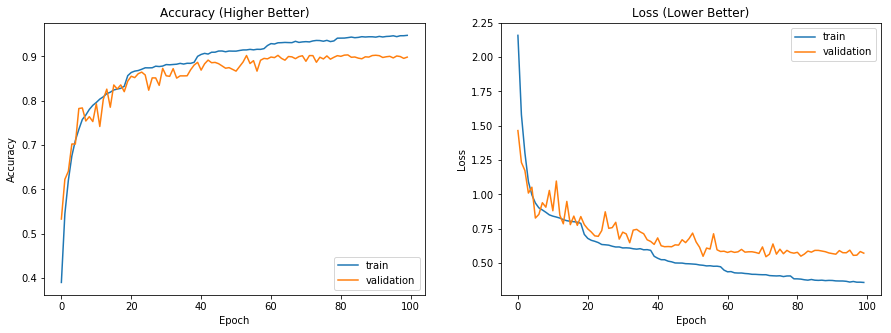

In [33]:
# Customise Lenet with repeating Convolutions and increasing twice the number of filters

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
 
#z-score
mean = np.mean(x_train,axis=(0,1,2,3))
std = np.std(x_train,axis=(0,1,2,3))
x_train = (x_train-mean)/(std+1e-7)
x_test = (x_test-mean)/(std+1e-7)

y_train = np_utils.to_categorical(y_train,num_classes)
y_test = np_utils.to_categorical(y_test,num_classes)

datagen = ImageDataGenerator(rotation_range=10, horizontal_flip=True,
            width_shift_range=0.125,height_shift_range=0.125,fill_mode='constant',cval=0.)
datagen.fit(x_train)

weight_decay = 1e-4
model = Sequential()

# increase number of filters by x 2 and introduce additional layer of convolution
model.add(Conv2D(64, kernel_size=(3,3), 
                        strides=(1,1),
                        padding='same', # adds sufficient padding to the input so that the output has same dimension as input
                        input_shape=x_train.shape[1:],
                        use_bias=False, 
                        kernel_initializer='glorot_uniform',
                        kernel_regularizer=regularizers.l2(weight_decay),
                        bias_initializer='zeros'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, kernel_size=(3,3), 
                        strides=(1,1),
                        padding='same', # adds sufficient padding to the input so that the output has same dimension as input
                        input_shape=x_train.shape[1:],
                        use_bias=False, 
                        kernel_initializer='glorot_uniform',
                        kernel_regularizer=regularizers.l2(weight_decay),
                        bias_initializer='zeros'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.2))

# increase number of filters by x 2 and introduce additional layer of convolution
model.add(Conv2D(128, kernel_size=(3,3), 
                        strides=(1,1),
                        padding='same', # adds sufficient padding to the input so that the output has same dimension as input
                        input_shape=x_train.shape[1:],
                        use_bias=False, 
                        kernel_initializer='glorot_uniform',
                        kernel_regularizer=regularizers.l2(weight_decay),
                        bias_initializer='zeros'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(128, kernel_size=(3,3), 
                        strides=(1,1),
                        padding='same', # adds sufficient padding to the input so that the output has same dimension as input
                        input_shape=x_train.shape[1:],
                        use_bias=False, 
                        kernel_initializer='glorot_uniform',
                        kernel_regularizer=regularizers.l2(weight_decay),
                        bias_initializer='zeros'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.3))

# increase number of filters by x 2 and introduce additional layer of convolution
model.add(Conv2D(256, kernel_size=(3,3), 
                        strides=(1,1),
                        padding='same', # adds sufficient padding to the input so that the output has same dimension as input
                        input_shape=x_train.shape[1:],
                        use_bias=False, 
                        kernel_initializer='glorot_uniform',
                        kernel_regularizer=regularizers.l2(weight_decay),
                        bias_initializer='zeros'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(256, kernel_size=(3,3), 
                        strides=(1,1),
                        padding='same', # adds sufficient padding to the input so that the output has same dimension as input
                        input_shape=x_train.shape[1:],
                        use_bias=False, 
                        kernel_initializer='glorot_uniform',
                        kernel_regularizer=regularizers.l2(weight_decay),
                        bias_initializer='zeros'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.4))



model.add(Flatten())
# keep only last layer as Dense for classification
model.add(Dense(num_classes,kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('softmax'))

model.summary()
#change optimizer back to RMS
opt_rms = keras.optimizers.rmsprop(lr=0.001,decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])
model_log = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),\
                    steps_per_epoch=x_train.shape[0] // batch_size,epochs=epochs,\
                    verbose=1,validation_data=(x_test,y_test),callbacks=[LearningRateScheduler(learning_schedule)])

plot_accuracy_loss(model_log) 

#save to disk
model_json = model.to_json()
with open('4_2xCon2D_'+custom_lenet5_model_name, 'w') as json_file:
    json_file.write(model_json)
model.save_weights('4_2xConv2D_'+custom_lenet5_weight_name) 
  
#testing
scores = model.evaluate(x_test, y_test, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

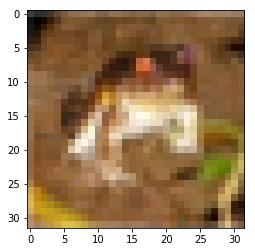

['frog']


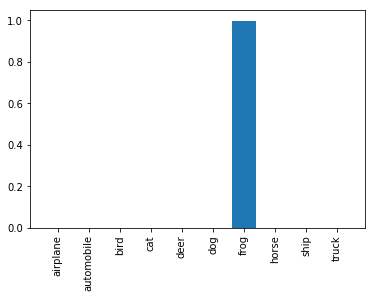

In [34]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
 
x_train = x_train.astype('float32')

pyplot.imshow(x_train[0].astype('uint8'), cmap = 'gray')
pyplot.show()
print ([labels[x] for x in y_train[0]])

mean = np.mean(x_train,axis=(0,1,2,3))
std = np.std(x_train,axis=(0,1,2,3))
x_train = (x_train-mean)/(std+1e-7)
x_test = (x_test-mean)/(std+1e-7)

layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(x_train[0].reshape(1,img_rows, img_cols, 3))

act_classification  = activations[len(activations)-1]
 
y = act_classification[0]
x = range(len(y))
pyplot.xticks(x, labels, rotation='vertical')
pyplot.bar(x, y)
pyplot.show()


By Steve Ng Yong Yu